# Import Packages

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf
import itertools
import os
from tensorflow.keras.layers import Input, LSTM, Dense, TimeDistributed, GRU, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm

### Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Test GRU GAN Model with Simple Generated Data

Epoch   0 | G Loss: 0.7212 | D Loss: 1.3939 | Recon MAE: 0.6498
Epoch  50 | G Loss: 0.1076 | D Loss: 1.7927 | Recon MAE: 0.0911
Epoch 100 | G Loss: 0.0757 | D Loss: 1.8991 | Recon MAE: 0.0592
Epoch 150 | G Loss: 0.0739 | D Loss: 1.8497 | Recon MAE: 0.0533
Epoch 200 | G Loss: 0.0643 | D Loss: 1.8745 | Recon MAE: 0.0439
Epoch 250 | G Loss: 0.0536 | D Loss: 2.3006 | Recon MAE: 0.0399
Epoch 299 | G Loss: 0.0634 | D Loss: 1.8084 | Recon MAE: 0.0380
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/step


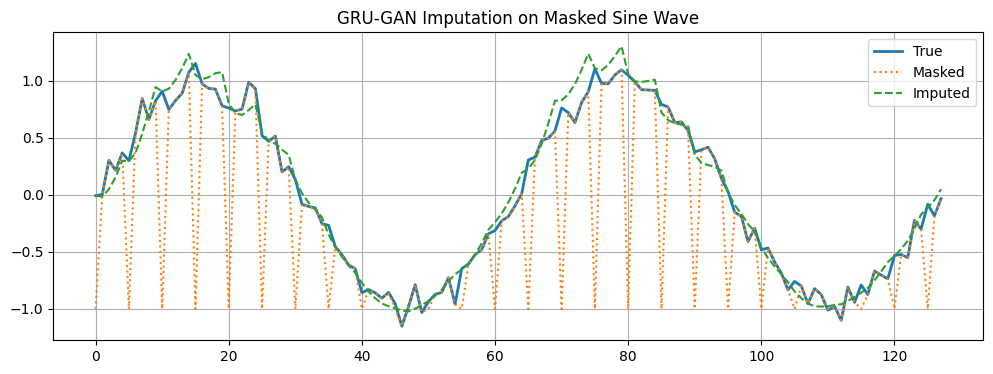

In [ ]:
# ======= Generate Sine Wave with 20% Missing =======
seq_len = 128
x = np.linspace(0, 4 * np.pi, seq_len)
original = np.sin(x) + 0.1 * np.random.randn(seq_len)

masked = original.copy()
masked[::5] = -1.0
mask = np.ones_like(original)
mask[::5] = 0

X_input = masked.reshape((1, seq_len, 1)).astype(np.float32)
Y_true = original.reshape((1, seq_len, 1)).astype(np.float32)
mask = mask.reshape((1, seq_len, 1)).astype(np.float32)

# ======= Models =======
def build_generator(seq_len=128):
    inp = Input(shape=(seq_len, 1))
    x = GRU(64, return_sequences=True)(inp)
    x = GRU(64, return_sequences=True)(x)
    out = TimeDistributed(Dense(1))(x)
    return Model(inp, out)

def build_discriminator(seq_len=128):
    inp = Input(shape=(seq_len, 1))
    x = GRU(64, return_sequences=True)(inp)
    x = GRU(64)(x)
    out = Dense(1, activation='sigmoid')(x)
    return Model(inp, out)

generator = build_generator()
discriminator = build_discriminator()

# ======= Training Setup =======
epochs = 300
lr = 0.001
g_opt = Adam(learning_rate=lr)
d_opt = Adam(learning_rate=lr)
bce = tf.keras.losses.BinaryCrossentropy()

for epoch in range(epochs):
    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        imputed = generator(X_input, training=True)
        combined = tf.where(mask == 1, X_input, imputed)

        real_logits = discriminator(Y_true, training=True)
        fake_logits = discriminator(combined, training=True)

        recon_loss = tf.reduce_sum(tf.abs((Y_true - imputed) * (1 - mask))) / tf.reduce_sum(1 - mask)
        gan_loss = bce(tf.ones_like(fake_logits), fake_logits)
        g_loss = recon_loss + 0.1 * gan_loss

        d_loss_real = bce(tf.random.uniform(tf.shape(real_logits), 0.8, 1.0), real_logits)
        d_loss_fake = bce(tf.random.uniform(tf.shape(fake_logits), 0.0, 0.2), fake_logits)
        d_loss = d_loss_real + d_loss_fake

    g_grads = g_tape.gradient(g_loss, generator.trainable_variables)
    d_grads = d_tape.gradient(d_loss, discriminator.trainable_variables)
    g_opt.apply_gradients(zip(g_grads, generator.trainable_variables))
    d_opt.apply_gradients(zip(d_grads, discriminator.trainable_variables))

    if epoch % 50 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch:>3} | G Loss: {g_loss:.4f} | D Loss: {d_loss:.4f} | Recon MAE: {recon_loss:.4f}")

# ======= Plot Result =======
imputed_result = generator.predict(X_input)[0, :, 0]

plt.figure(figsize=(12, 4))
plt.plot(original, label="True", linewidth=2)
plt.plot(masked, label="Masked", linestyle="dotted")
plt.plot(imputed_result, label="Imputed", linestyle="--")
plt.title("GRU-GAN Imputation on Masked Sine Wave")
plt.legend()
plt.grid(True)
plt.show()


# Import Dataset and Setup

In [4]:
metered_path = "/content/drive/MyDrive/DeepLearning/GAN/metered_data.xlsx"
df = pd.read_excel(metered_path)

In [5]:
pjm_2024 = df[df['year'] == 2024].copy().reset_index(drop=True)
pjm_2024 = pjm_2024.iloc[:100]

# Extract the 'mw' values as a NumPy array
series = pjm_2024['mw'].values.astype(np.float32)

# Normalize (optional but helps training)
mean, std = np.mean(series), np.std(series)
series_norm = (series - mean) / std

# Function to create overlapping masked sequences
def prepare_pjm_sequences(series, seq_len=32, step=8, missing_rate=0.2, placeholder=-1.0):
    sequences, masked_seqs, masks = [], [], []
    for i in range(0, len(series) - seq_len, step):
        seq = series[i:i+seq_len]
        mask = np.ones(seq_len)
        masked = seq.copy()
        miss_idx = np.random.choice(seq_len, size=int(missing_rate * seq_len), replace=False)
        masked[miss_idx] = placeholder
        mask[miss_idx] = 0
        sequences.append(seq)
        masked_seqs.append(masked)
        masks.append(mask)
    return (
        np.array(masked_seqs)[..., np.newaxis].astype(np.float32),
        np.array(sequences)[..., np.newaxis].astype(np.float32),
        np.array(masks)[..., np.newaxis].astype(np.float32)
    )

# Create overlapping sequences
X_input, Y_true, mask = prepare_pjm_sequences(series_norm, seq_len=32, step=8)

# Sanity check
print("Shape of input:", X_input.shape)
print("Example masked sequence:", X_input[0].flatten())

Shape of input: (9, 32, 1)
Example masked sequence: [-1.         -1.3608261  -1.         -1.         -1.362427   -1.1194233
 -0.84764266 -0.66690636 -0.6161491  -0.6826831  -1.         -0.7524867
 -0.7695219  -0.76666176 -1.         -0.5067295  -1.          0.5070022
  0.5645128   0.45319468  0.25726914 -0.02461262 -0.5140798  -0.93003684
 -1.1802894  -1.3332347  -1.3548298  -1.2266588  -0.8606255  -0.16787215
  0.7679667   1.3874413 ]


# GRU GAN Model

### Full Year Implementation

Epoch   0 | G Loss: 0.8578 | D Loss: 1.3851 | Recon MAE: 0.7891
Epoch  10 | G Loss: 0.5653 | D Loss: 1.4605 | Recon MAE: 0.5063
Epoch  20 | G Loss: 0.4603 | D Loss: 1.6849 | Recon MAE: 0.4186
Epoch  30 | G Loss: 0.3795 | D Loss: 2.3043 | Recon MAE: 0.3620
Epoch  40 | G Loss: 0.3452 | D Loss: 2.4305 | Recon MAE: 0.3340
Epoch  50 | G Loss: 0.3276 | D Loss: 2.3538 | Recon MAE: 0.3161
Epoch  60 | G Loss: 0.3147 | D Loss: 2.3462 | Recon MAE: 0.3031
Epoch  70 | G Loss: 0.3046 | D Loss: 2.2552 | Recon MAE: 0.2917
Epoch  80 | G Loss: 0.2954 | D Loss: 2.2327 | Recon MAE: 0.2822
Epoch  90 | G Loss: 0.2887 | D Loss: 2.1570 | Recon MAE: 0.2741
Epoch  99 | G Loss: 0.2835 | D Loss: 2.1113 | Recon MAE: 0.2674
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step


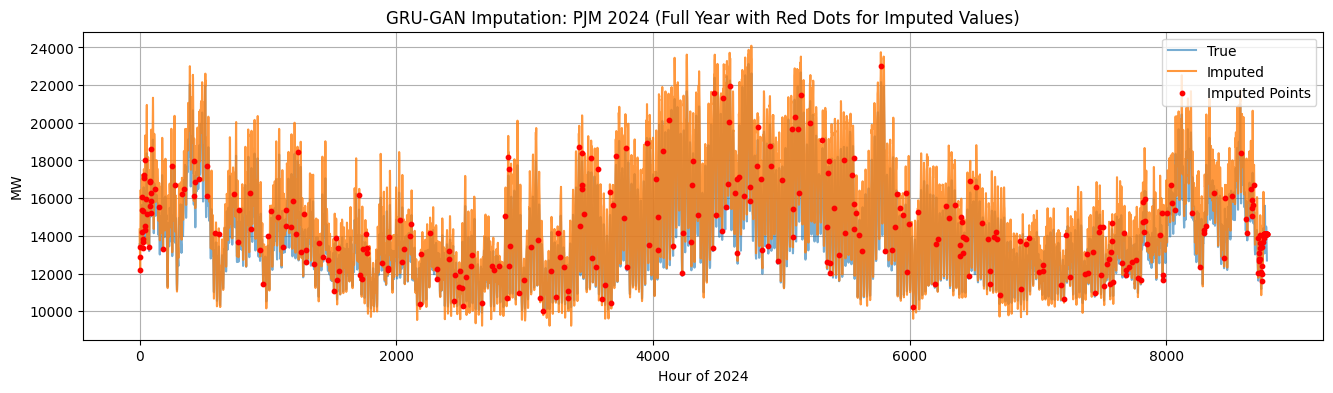

In [ ]:
# ================== Load & Normalize ==================
pjm = df[df['year'] == 2024].reset_index(drop=True)
series = pjm['mw'].values.astype(np.float32)

mean = np.mean(series)
std = np.std(series)
series_norm = (series - mean) / std

# ================== Slice Into Chunks ==================
def slice_sequences(series, seq_len=168, step=24, missing_rate=0.2, placeholder=-1.0):
    masked_seqs, true_seqs, masks = [], [], []
    for i in range(0, len(series) - seq_len, step):
        seq = series[i:i+seq_len]
        mask = np.ones(seq_len)
        masked = seq.copy()
        miss_idx = np.random.choice(seq_len, int(missing_rate * seq_len), replace=False)
        masked[miss_idx] = placeholder
        mask[miss_idx] = 0
        masked_seqs.append(masked)
        true_seqs.append(seq)
        masks.append(mask)
    return (
        np.array(masked_seqs)[..., np.newaxis].astype(np.float32),
        np.array(true_seqs)[..., np.newaxis].astype(np.float32),
        np.array(masks)[..., np.newaxis].astype(np.float32)
    )

X_input, Y_true, mask = slice_sequences(series_norm, seq_len=168, step=24)

# ================== Build GRU-GAN ==================
def build_generator(seq_len):
    inp = Input(shape=(seq_len, 1))
    x = GRU(64, return_sequences=True)(inp)
    x = GRU(64, return_sequences=True)(x)
    out = TimeDistributed(Dense(1))(x)
    return Model(inp, out)

def build_discriminator(seq_len):
    inp = Input(shape=(seq_len, 1))
    x = GRU(64, return_sequences=True)(inp)
    x = GRU(64)(x)
    out = Dense(1, activation='sigmoid')(x)
    return Model(inp, out)

seq_len = X_input.shape[1]
generator = build_generator(seq_len)
discriminator = build_discriminator(seq_len)

# ================== Train Loop ==================
epochs = 100
g_opt = Adam(0.001)
d_opt = Adam(0.001)
bce = tf.keras.losses.BinaryCrossentropy()

for epoch in range(epochs):
    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        imputed = generator(X_input, training=True)
        combined = tf.where(mask == 1, X_input, imputed)

        real_logits = discriminator(Y_true, training=True)
        fake_logits = discriminator(combined, training=True)

        recon_loss = tf.reduce_sum(tf.abs((Y_true - imputed) * (1 - mask))) / tf.reduce_sum(1 - mask)
        gan_loss = bce(tf.ones_like(fake_logits), fake_logits)
        g_loss = recon_loss + 0.1 * gan_loss

        d_loss_real = bce(tf.random.uniform(tf.shape(real_logits), 0.8, 1.0), real_logits)
        d_loss_fake = bce(tf.random.uniform(tf.shape(fake_logits), 0.0, 0.2), fake_logits)
        d_loss = d_loss_real + d_loss_fake

    g_grads = g_tape.gradient(g_loss, generator.trainable_variables)
    d_grads = d_tape.gradient(d_loss, discriminator.trainable_variables)
    g_opt.apply_gradients(zip(g_grads, generator.trainable_variables))
    d_opt.apply_gradients(zip(d_grads, discriminator.trainable_variables))

    if epoch % 10 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch:>3} | G Loss: {g_loss:.4f} | D Loss: {d_loss:.4f} | Recon MAE: {recon_loss:.4f}")

# ================== Reconstruct Full Sequence ==================
imputed_chunks = generator.predict(X_input)[:, :, 0]

reconstructed = np.zeros_like(series_norm)
count = np.zeros_like(series_norm)

for i in range(imputed_chunks.shape[0]):
    start = i * 24
    end = start + 168
    if end > len(series_norm):
        break
    reconstructed[start:end] += imputed_chunks[i]
    count[start:end] += 1

reconstructed = np.divide(reconstructed, count, out=np.zeros_like(reconstructed), where=count != 0)
reconstructed = reconstructed * std + mean
true_series = series_norm * std + mean

# ================== Reconstruct Full Mask ==================
def reconstruct_mask(mask_chunks, seq_len=168, step=24, total_len=None):
    if total_len is None:
        total_len = (mask_chunks.shape[0] - 1) * step + seq_len
    full_mask = np.zeros(total_len)
    count = np.zeros(total_len)

    for i, m in enumerate(mask_chunks):
        start = i * step
        end = start + seq_len
        if end > total_len:
            break
        full_mask[start:end] += m.squeeze()
        count[start:end] += 1

    avg_mask = full_mask / np.maximum(count, 1)
    mask_all = (avg_mask > 0.5).astype(int)
    return mask_all

mask_all = reconstruct_mask(mask, seq_len=168, step=24, total_len=len(series_norm))

# ================== Plot Full Series with Red Dots ==================
missing_idx = np.where(mask_all == 0)[0]
imputed_values = reconstructed[missing_idx]

plt.figure(figsize=(16, 4))
plt.plot(true_series, label="True", alpha=0.6)
plt.plot(reconstructed, label="Imputed", alpha=0.8)
plt.scatter(missing_idx, imputed_values, color="red", label="Imputed Points", s=10, zorder=5)
plt.title("GRU-GAN Imputation: PJM 2024 (Full Year with Red Dots for Imputed Values)")
plt.xlabel("Hour of 2024")
plt.ylabel("MW")
plt.legend()
plt.grid(True)
plt.show()


### Implementation with 4 Months Groups

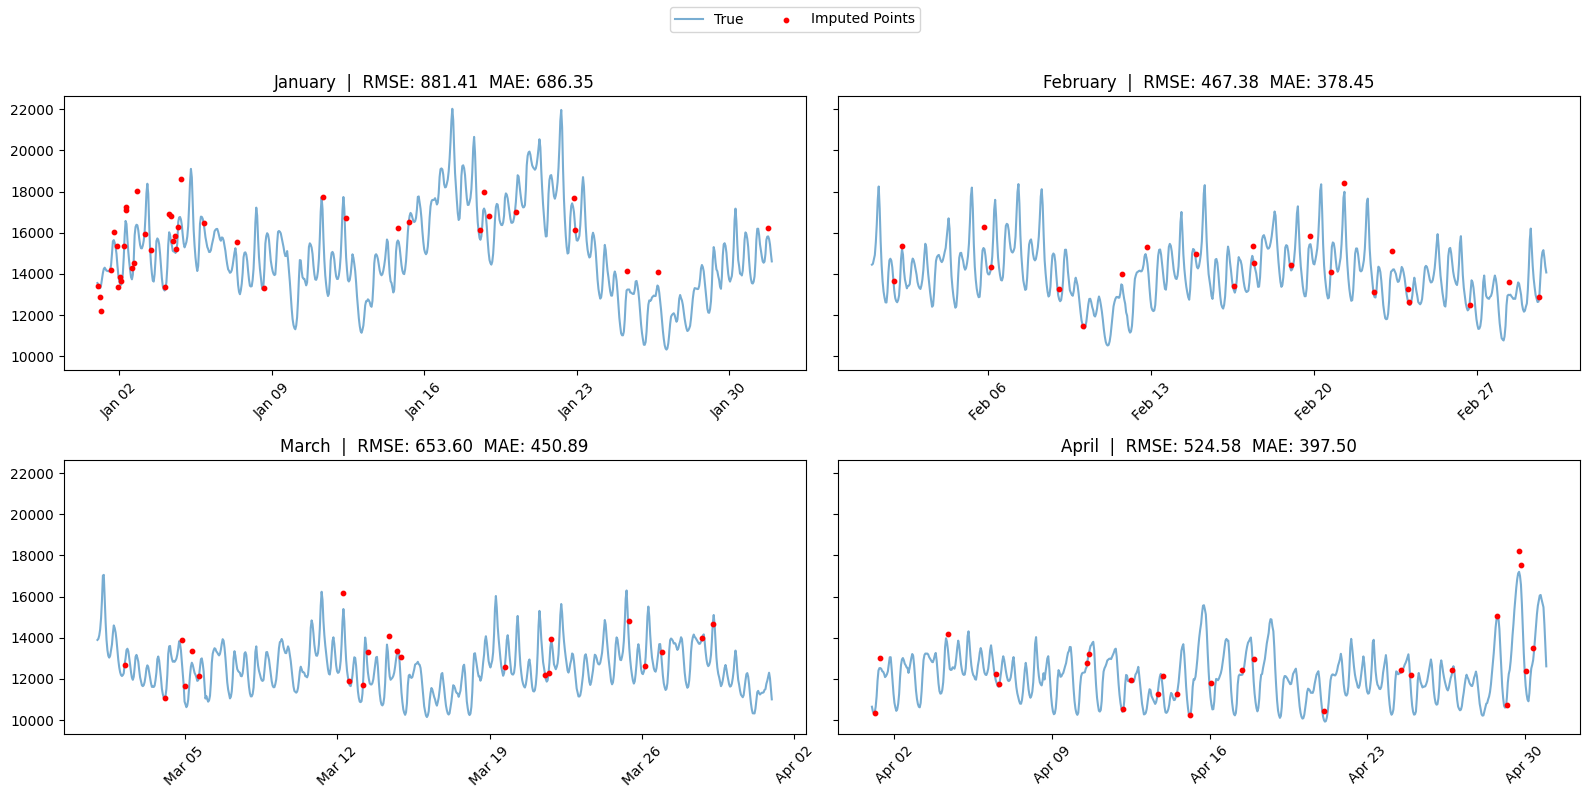

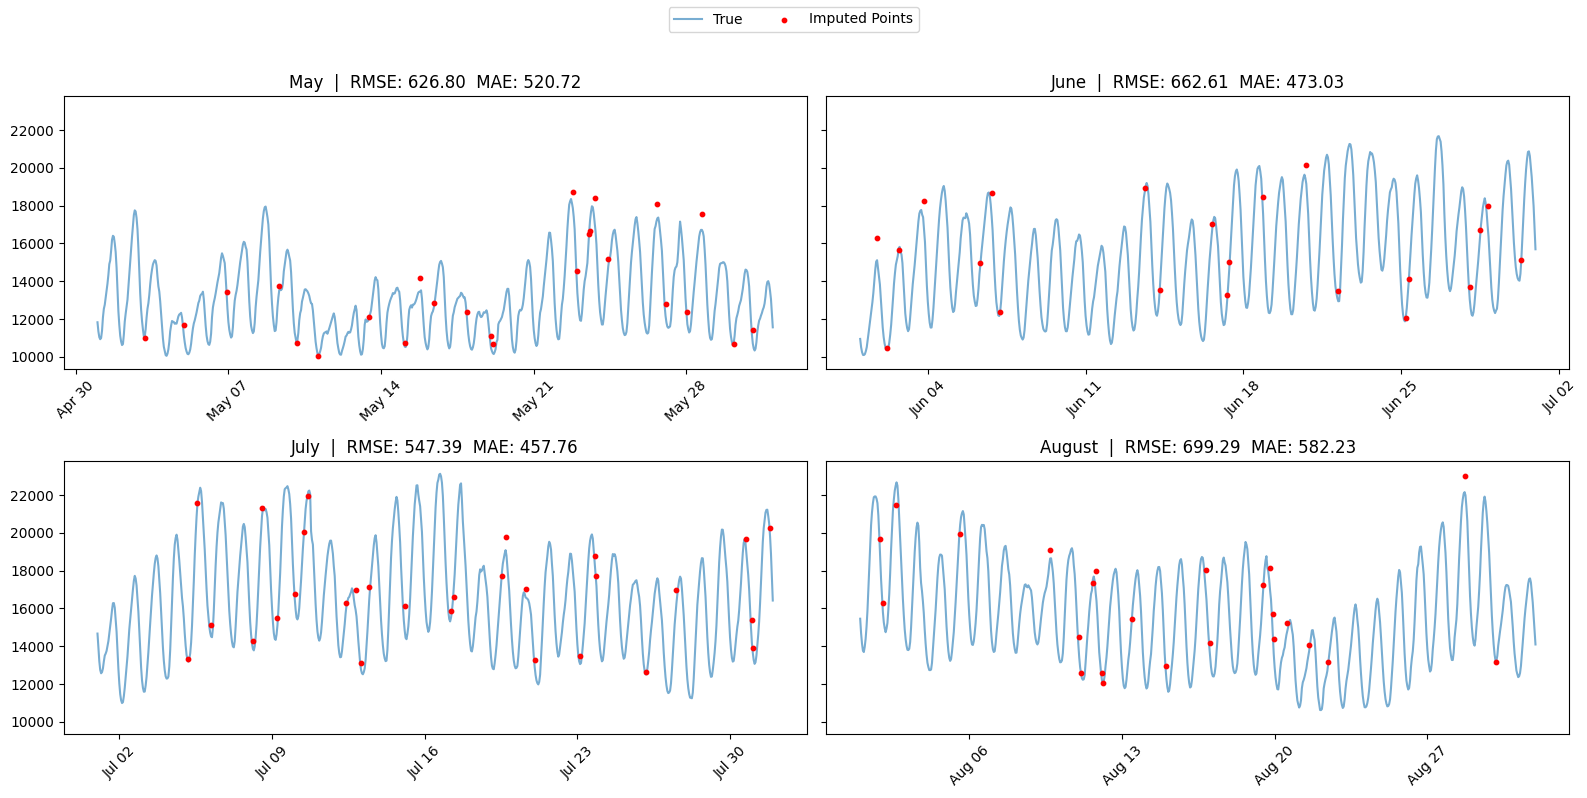

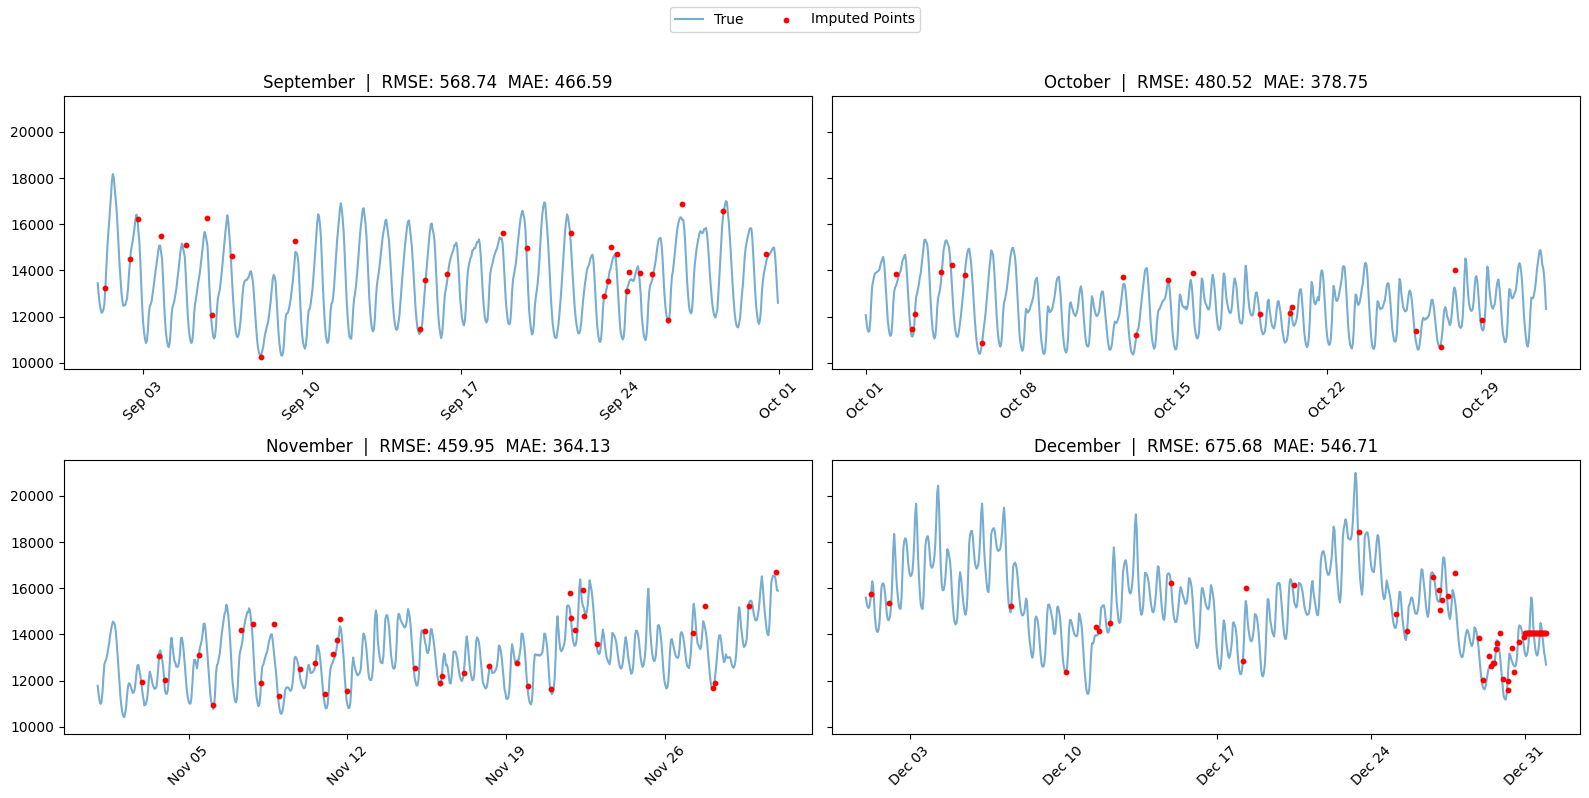

In [ ]:
# Merge everything
pjm_2024 = df[df['year'] == 2024].reset_index(drop=True).copy()
pjm_2024['datetime'] = pd.to_datetime(pjm_2024[['year', 'month', 'day', 'hour']])
pjm_2024['true_mw'] = true_series
pjm_2024['imputed_mw'] = reconstructed
pjm_2024['mask'] = mask_all  # 1 = observed, 0 = missing

# Split months into 3 groups
month_groups = [
    [1, 2, 3, 4],     # Jan–Apr
    [5, 6, 7, 8],     # May–Aug
    [9, 10, 11, 12],  # Sep–Dec
]

for idx, group in enumerate(month_groups):
    fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharey=True)
    axes = axes.flatten()

    for i, month in enumerate(group):
        ax = axes[i]
        month_df = pjm_2024[pjm_2024['month'] == month]
        missing = month_df[month_df['mask'] == 0]

        # Calculate RMSE and MAE on missing values
        if not missing.empty:
            rmse = np.sqrt(np.mean((missing['true_mw'] - missing['imputed_mw'])**2))
            mae = np.mean(np.abs(missing['true_mw'] - missing['imputed_mw']))
        else:
            rmse = np.nan
            mae = np.nan

        # Plot true values
        ax.plot(month_df['datetime'], month_df['true_mw'], label='True', alpha=0.6)

        # Red dots at imputed locations
        ax.scatter(missing['datetime'], missing['imputed_mw'], color='red', s=10, label='Imputed Points', zorder=5)

        # Title with metrics
        month_name = pd.Timestamp(2024, month, 1).strftime('%B')
        ax.set_title(f"{month_name}  |  RMSE: {rmse:.2f}  MAE: {mae:.2f}")

        ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
        ax.tick_params(axis='x', rotation=45)

    # Hide unused subplots
    for j in range(len(group), 4):
        fig.delaxes(axes[j])

    fig.tight_layout(rect=[0, 0, 1, 0.93])
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=3)

    plt.show()


### Implementation for each Month

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step


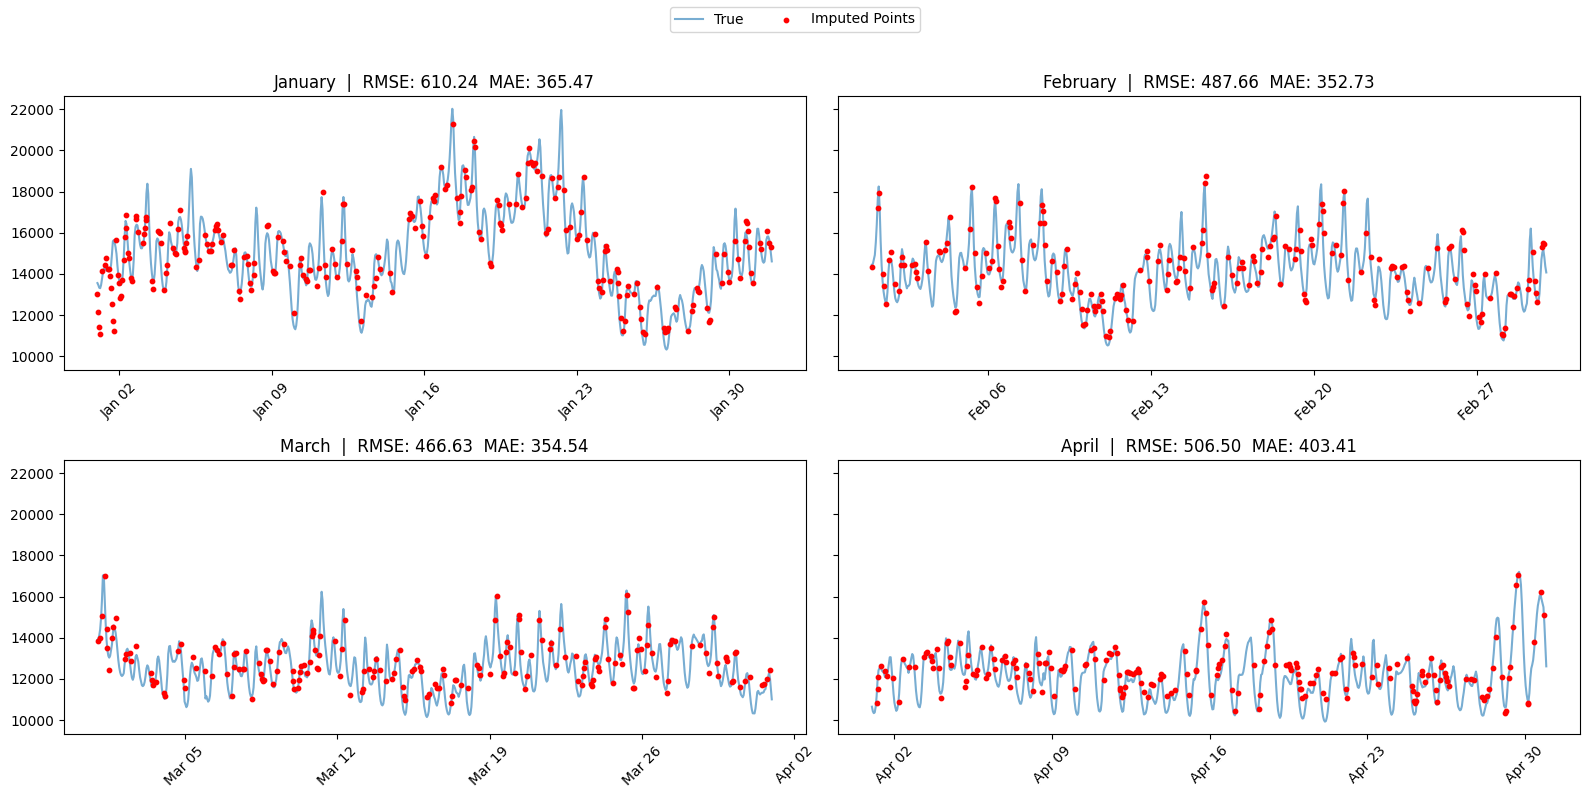

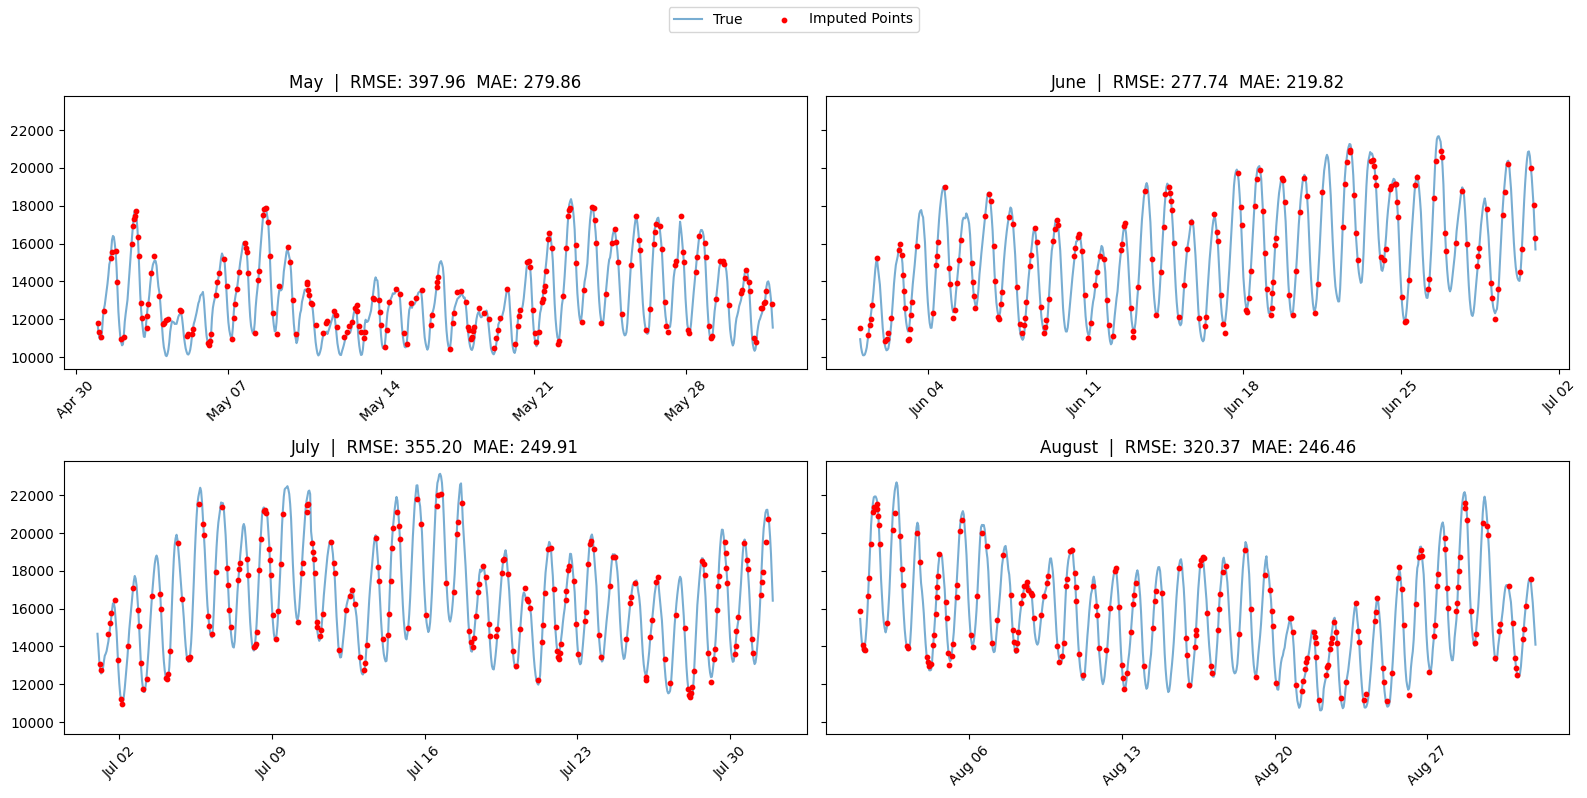

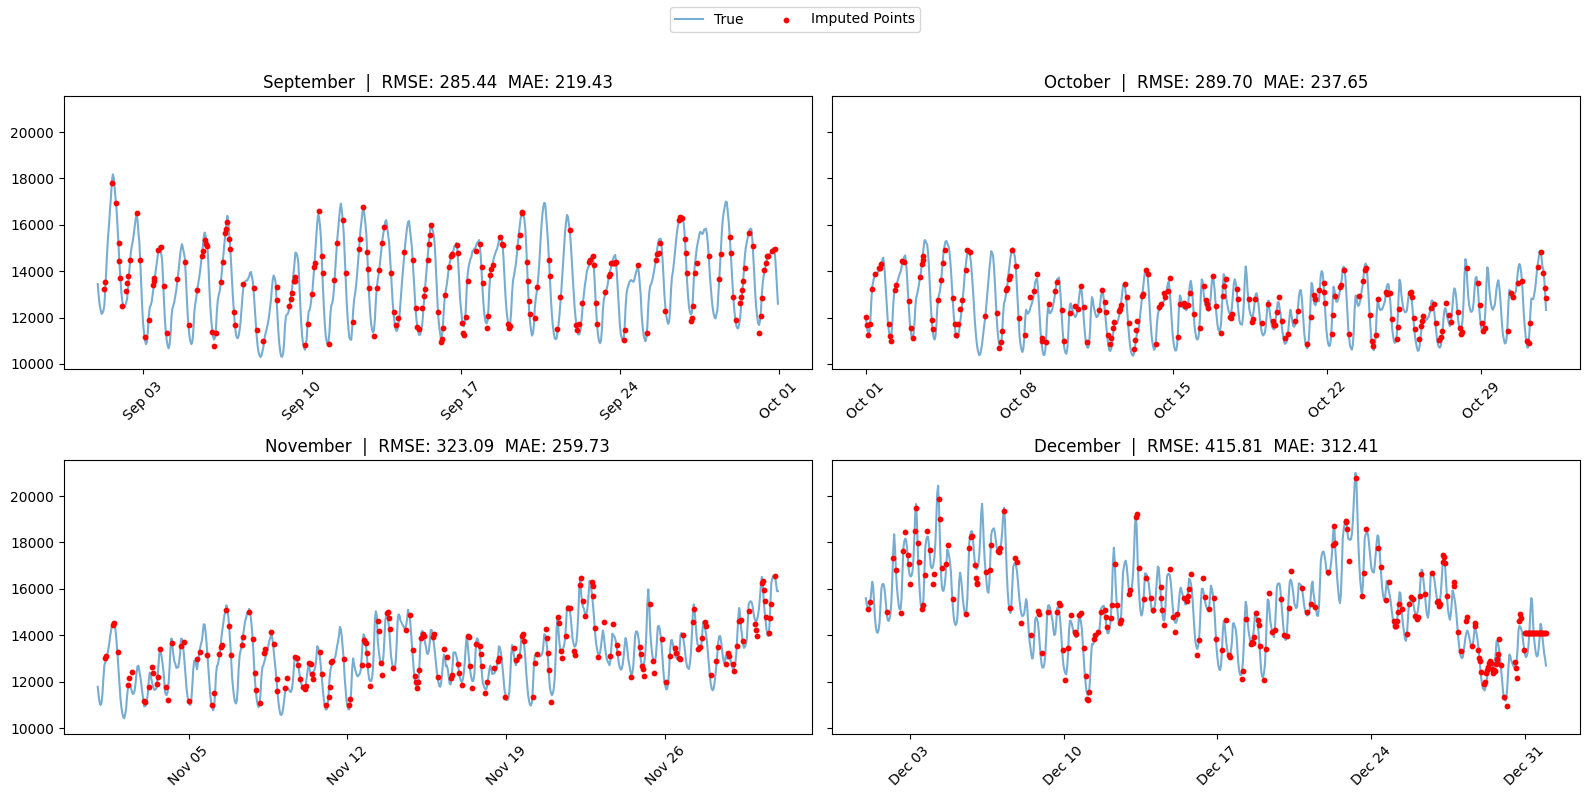

In [ ]:
# === Load Best Model ===
best_model_path = 'model_ep100_lr0.005_miss40.h5'  # example
generator = tf.keras.models.load_model(best_model_path)

# === Preprocess Full 2024 Series ===
pjm_2024 = df[df['year'] == 2024].reset_index(drop=True)
series = pjm_2024['mw'].values.astype(np.float32)

mean, std = np.mean(series), np.std(series)
series_norm = (series - mean) / std

# === Slice Into Overlapping Chunks ===
def slice_sequences(series, seq_len=168, step=24, missing_rate=0.4, placeholder=-1.0):
    masked_seqs, true_seqs, masks = [], [], []
    for i in range(0, len(series) - seq_len, step):
        seq = series[i:i+seq_len]
        mask = np.ones(seq_len)
        masked = seq.copy()
        miss_idx = np.random.choice(seq_len, int(missing_rate * seq_len), replace=False)
        masked[miss_idx] = placeholder
        mask[miss_idx] = 0
        masked_seqs.append(masked)
        true_seqs.append(seq)
        masks.append(mask)
    return (
        np.array(masked_seqs)[..., np.newaxis],
        np.array(true_seqs)[..., np.newaxis],
        np.array(masks)[..., np.newaxis]
    )

X_input, Y_true, mask = slice_sequences(series_norm)

# === Reconstruct ===
imputed_chunks = generator.predict(X_input)[:, :, 0]

def reconstruct_full_sequence(chunks, total_len, seq_len=168, step=24):
    full = np.zeros(total_len)
    count = np.zeros(total_len)
    for i in range(chunks.shape[0]):
        start = i * step
        end = start + seq_len
        if end > total_len:
            break
        full[start:end] += chunks[i]
        count[start:end] += 1
    return np.divide(full, count, out=np.zeros_like(full), where=count != 0)

reconstructed = reconstruct_full_sequence(imputed_chunks, len(series_norm))
reconstructed = reconstructed * std + mean
true_series = series_norm * std + mean

# === Reconstruct Full Mask ===
def reconstruct_mask(mask_chunks, seq_len=168, step=24, total_len=None):
    if total_len is None:
        total_len = (mask_chunks.shape[0] - 1) * step + seq_len
    full_mask = np.zeros(total_len)
    count = np.zeros(total_len)
    for i, m in enumerate(mask_chunks):
        start = i * step
        end = start + seq_len
        if end > total_len:
            break
        full_mask[start:end] += m.squeeze()
        count[start:end] += 1
    avg_mask = full_mask / np.maximum(count, 1)
    return (avg_mask > 0.5).astype(int)

mask_all = reconstruct_mask(mask, total_len=len(series_norm))

# === Monthly Plotting ===
pjm_2024['datetime'] = pd.to_datetime(pjm_2024[['year', 'month', 'day', 'hour']])
pjm_2024['true_mw'] = true_series
pjm_2024['imputed_mw'] = reconstructed
pjm_2024['mask'] = mask_all  # 1 = observed, 0 = missing

month_groups = [[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12]]

for idx, group in enumerate(month_groups):
    fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharey=True)
    axes = axes.flatten()

    for i, month in enumerate(group):
        ax = axes[i]
        month_df = pjm_2024[pjm_2024['month'] == month]
        missing = month_df[month_df['mask'] == 0]

        if not missing.empty:
            rmse = np.sqrt(np.mean((missing['true_mw'] - missing['imputed_mw'])**2))
            mae = np.mean(np.abs(missing['true_mw'] - missing['imputed_mw']))
        else:
            rmse = mae = np.nan

        ax.plot(month_df['datetime'], month_df['true_mw'], label='True', alpha=0.6)
        ax.scatter(missing['datetime'], missing['imputed_mw'], color='red', s=10, label='Imputed Points', zorder=5)

        title = f"{pd.Timestamp(2024, month, 1).strftime('%B')}  |  RMSE: {rmse:.2f}  MAE: {mae:.2f}"
        ax.set_title(title)
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
        ax.tick_params(axis='x', rotation=45)

    for j in range(len(group), 4):
        fig.delaxes(axes[j])

    fig.tight_layout(rect=[0, 0, 1, 0.93])
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=3)
    plt.show()

# Testing GRU-GAN Model with Different Hyperparameter Settings and Different Missing Data Rate

In [ ]:
def train_gru_gan(X_input, Y_true, mask, epochs, lr, generator, discriminator):
    g_opt = Adam(lr)
    d_opt = Adam(lr)
    bce = tf.keras.losses.BinaryCrossentropy()

    for epoch in tqdm(range(epochs), desc=f"Training (lr={lr}, epochs={epochs})"):
        with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
            imputed = generator(X_input, training=True)
            combined = tf.where(mask == 1, X_input, imputed)

            real_logits = discriminator(Y_true, training=True)
            fake_logits = discriminator(combined, training=True)

            recon_loss = tf.reduce_sum(tf.abs((Y_true - imputed) * (1 - mask))) / tf.reduce_sum(1 - mask)
            gan_loss = bce(tf.ones_like(fake_logits), fake_logits)
            g_loss = recon_loss + 0.1 * gan_loss

            d_loss_real = bce(tf.random.uniform(tf.shape(real_logits), 0.8, 1.0), real_logits)
            d_loss_fake = bce(tf.random.uniform(tf.shape(fake_logits), 0.0, 0.2), fake_logits)
            d_loss = d_loss_real + d_loss_fake

        g_grads = g_tape.gradient(g_loss, generator.trainable_variables)
        d_grads = d_tape.gradient(d_loss, discriminator.trainable_variables)
        g_opt.apply_gradients(zip(g_grads, generator.trainable_variables))
        d_opt.apply_gradients(zip(d_grads, discriminator.trainable_variables))

    return generator

In [ ]:
def run_experiments(series, param_grid, seq_len=168, step=24):
    series_norm, mean, std = normalize_series(series)
    results = []

    for missing_rate in param_grid['missing_rate']:
        for lr in param_grid['learning_rate']:
            for epochs in param_grid['epochs']:
                X_input, Y_true, mask = slice_sequences(series_norm, seq_len, step, missing_rate)
                generator = build_generator(seq_len)
                discriminator = build_discriminator(seq_len)
                trained_gen = train_gru_gan(X_input, Y_true, mask, epochs, lr, generator, discriminator)

                # Reconstruct
                imputed_chunks = trained_gen.predict(X_input)[:, :, 0]
                recon_norm = reconstruct_full_sequence(imputed_chunks, len(series_norm), seq_len, step)
                recon = recon_norm * std + mean
                true = series_norm * std + mean
                mask_all = reconstruct_mask(mask, seq_len, step, len(series_norm))

                # Only compute error on missing entries
                mae = np.mean(np.abs(true[mask_all == 0] - recon[mask_all == 0]))

                results.append({
                    'missing_rate': missing_rate,
                    'learning_rate': lr,
                    'epochs': epochs,
                    'MAE': mae
                })

                fname = f"model_ep{epochs}_lr{lr}_miss{int(missing_rate*100)}.h5"
                trained_gen.save(fname)

    return pd.DataFrame(results)

In [ ]:
pjm = df[df['year'] == 2024].reset_index(drop=True)
series = pjm['mw'].values.astype(np.float32)

# Define param grid for 24 combinations
param_grid = {
    'missing_rate': [0.1, 0.2, 0.3, 0.4],
    'learning_rate': [0.001, 0.003, 0.005],
    'epochs': [25, 50, 75, 100]
}

# Run experiments
results_df = run_experiments(series, param_grid)

# Save results
results_df.to_csv("gru_gan_results.csv", index=False)
results_df

Training (lr=0.001, epochs=25): 100%|██████████| 25/25 [00:22<00:00,  1.13it/s]


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step


Training (lr=0.001, epochs=50): 100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step


Training (lr=0.001, epochs=75): 100%|██████████| 75/75 [01:09<00:00,  1.08it/s]


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step


Training (lr=0.001, epochs=100): 100%|██████████| 100/100 [01:29<00:00,  1.12it/s]


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step


Training (lr=0.003, epochs=25): 100%|██████████| 25/25 [00:22<00:00,  1.10it/s]


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step


Training (lr=0.003, epochs=50): 100%|██████████| 50/50 [00:44<00:00,  1.13it/s]


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step


Training (lr=0.003, epochs=75): 100%|██████████| 75/75 [01:07<00:00,  1.12it/s]


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step


Training (lr=0.003, epochs=100): 100%|██████████| 100/100 [01:28<00:00,  1.13it/s]


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step


Training (lr=0.005, epochs=25): 100%|██████████| 25/25 [00:22<00:00,  1.13it/s]


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step


Training (lr=0.005, epochs=50): 100%|██████████| 50/50 [00:44<00:00,  1.14it/s]


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step


Training (lr=0.005, epochs=75): 100%|██████████| 75/75 [01:06<00:00,  1.12it/s]


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step


Training (lr=0.005, epochs=100): 100%|██████████| 100/100 [01:29<00:00,  1.11it/s]


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step


Training (lr=0.001, epochs=25): 100%|██████████| 25/25 [00:22<00:00,  1.12it/s]


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step


Training (lr=0.001, epochs=50): 100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step


Training (lr=0.001, epochs=75): 100%|██████████| 75/75 [01:06<00:00,  1.13it/s]


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step


Training (lr=0.001, epochs=100): 100%|██████████| 100/100 [01:29<00:00,  1.12it/s]


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step


Training (lr=0.003, epochs=25): 100%|██████████| 25/25 [00:22<00:00,  1.10it/s]


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step


Training (lr=0.003, epochs=50): 100%|██████████| 50/50 [00:44<00:00,  1.13it/s]


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step


Training (lr=0.003, epochs=75): 100%|██████████| 75/75 [01:07<00:00,  1.11it/s]


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step


Training (lr=0.003, epochs=100): 100%|██████████| 100/100 [01:29<00:00,  1.12it/s]


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step


Training (lr=0.005, epochs=25): 100%|██████████| 25/25 [00:22<00:00,  1.11it/s]


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step


Training (lr=0.005, epochs=50): 100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step


Training (lr=0.005, epochs=75): 100%|██████████| 75/75 [01:07<00:00,  1.12it/s]


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step


Training (lr=0.005, epochs=100): 100%|██████████| 100/100 [01:31<00:00,  1.10it/s]


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step


Training (lr=0.001, epochs=25): 100%|██████████| 25/25 [00:22<00:00,  1.10it/s]


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step


Training (lr=0.001, epochs=50): 100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step


Training (lr=0.001, epochs=75): 100%|██████████| 75/75 [01:07<00:00,  1.11it/s]


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step


Training (lr=0.001, epochs=100): 100%|██████████| 100/100 [01:29<00:00,  1.12it/s]


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step


Training (lr=0.003, epochs=25): 100%|██████████| 25/25 [00:22<00:00,  1.11it/s]


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step


Training (lr=0.003, epochs=50): 100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step


Training (lr=0.003, epochs=75): 100%|██████████| 75/75 [01:08<00:00,  1.09it/s]


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step


Training (lr=0.003, epochs=100): 100%|██████████| 100/100 [01:31<00:00,  1.10it/s]


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step


Training (lr=0.005, epochs=25): 100%|██████████| 25/25 [00:22<00:00,  1.13it/s]


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step


Training (lr=0.005, epochs=50): 100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step


Training (lr=0.005, epochs=75): 100%|██████████| 75/75 [01:07<00:00,  1.10it/s]


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step


Training (lr=0.005, epochs=100): 100%|██████████| 100/100 [01:28<00:00,  1.13it/s]


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step


Training (lr=0.001, epochs=25): 100%|██████████| 25/25 [00:22<00:00,  1.13it/s]


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step


Training (lr=0.001, epochs=50): 100%|██████████| 50/50 [00:43<00:00,  1.14it/s]


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step


Training (lr=0.001, epochs=75): 100%|██████████| 75/75 [01:06<00:00,  1.12it/s]


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step


Training (lr=0.001, epochs=100): 100%|██████████| 100/100 [01:31<00:00,  1.10it/s]


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step


Training (lr=0.003, epochs=25): 100%|██████████| 25/25 [00:22<00:00,  1.11it/s]


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step


Training (lr=0.003, epochs=50): 100%|██████████| 50/50 [00:44<00:00,  1.13it/s]


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step


Training (lr=0.003, epochs=75): 100%|██████████| 75/75 [01:07<00:00,  1.12it/s]


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step


Training (lr=0.003, epochs=100): 100%|██████████| 100/100 [01:29<00:00,  1.12it/s]


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step


Training (lr=0.005, epochs=25): 100%|██████████| 25/25 [00:22<00:00,  1.13it/s]


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step


Training (lr=0.005, epochs=50): 100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step


Training (lr=0.005, epochs=75): 100%|██████████| 75/75 [01:08<00:00,  1.09it/s]


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step


Training (lr=0.005, epochs=100): 100%|██████████| 100/100 [01:29<00:00,  1.11it/s]


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step


,missing_rate,learning_rate,epochs,MAE
0,0.1,0.001,25,664.572472
1,0.1,0.001,50,591.099796
2,0.1,0.001,75,611.874101
3,0.1,0.001,100,728.257208
4,0.1,0.003,25,684.643083
5,0.1,0.003,50,809.190301
6,0.1,0.003,75,772.212467
7,0.1,0.003,100,827.055760
8,0.1,0.005,25,720.875851
9,0.1,0.005,50,1357.124062


### Change More Settings

In [8]:
# Hyperparameter
layers_list = [1, 2, 3]
batch_sizes = [8, 16, 32, 64]
epochs_list = [25, 50, 75]
learning_rates = [0.001, 0.005, 0.01]

### 64 GRU Units / Different Hyperparmeter Setting

In [30]:
# Step 0: Import needed modules
import itertools
from tqdm import tqdm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, TimeDistributed
from tensorflow.keras.optimizers import Adam

# Step 1: Define the generator function BEFORE using it
def build_generator(seq_len, num_layers):
    inp = Input(shape=(seq_len, 1))
    x = inp
    for _ in range(num_layers):
        x = GRU(64, return_sequences=True)(x)
    out = TimeDistributed(Dense(1))(x)
    return Model(inp, out)

# Step 2: Define hyperparameter grid
layers_list = [1, 2, 3]
batch_sizes = [8, 16, 32, 64]
epochs_list = [25, 50, 300]
learning_rates = [0.001, 0.005, 0.01]

# Step 3: Define missing rates and run simulation
missing_rate_list = [0.2, 0.3, 0.4, 0.5]
results = []

for missing_rate in missing_rate_list:
    print(f"\n📌 Generating data with missing rate = {missing_rate:.1f}")

    X_input, Y_true, mask = prepare_pjm_sequences(
        series_norm, seq_len=32, step=8, missing_rate=missing_rate
    )

    for layers, batch_size, epochs, lr in tqdm(
        itertools.product(layers_list, batch_sizes, epochs_list, learning_rates),
        total=108, desc=f"Missing Rate {missing_rate}"
    ):
        # Build and compile generator
        generator = build_generator(seq_len=32, num_layers=layers)
        optimizer = Adam(learning_rate=lr)

        # Train generator with reconstruction loss
        for epoch in range(epochs):
            for i in range(0, len(X_input), batch_size):
                x_batch = X_input[i:i+batch_size]
                y_batch = Y_true[i:i+batch_size]
                m_batch = mask[i:i+batch_size]

                with tf.GradientTape() as tape:
                    imputed = generator(x_batch, training=True)
                    one_tensor = tf.constant(1.0, dtype=tf.float32)
                    epsilon = tf.constant(1e-8, dtype=tf.float32)
                    loss_num = tf.reduce_sum(tf.abs((y_batch - imputed) * (one_tensor - m_batch)))
                    loss_den = tf.reduce_sum(one_tensor - m_batch)
                    loss = loss_num / (loss_den + epsilon)

                grads = tape.gradient(loss, generator.trainable_variables)
                optimizer.apply_gradients(zip(grads, generator.trainable_variables))

        # Evaluation
        imputed = generator(X_input, training=False).numpy()
        true_vals = Y_true[mask == 0] * std + mean
        imputed_vals = imputed[mask == 0] * std + mean

        rmse = np.sqrt(np.mean((true_vals - imputed_vals) ** 2))
        mae = np.mean(np.abs(true_vals - imputed_vals))

        results.append({
            "Missing Rate": missing_rate,
            "Layers": layers,
            "Batch Size": batch_size,
            "Epochs": epochs,
            "Learning Rate": lr,
            "RMSE": round(float(rmse), 4),
            "MAE": round(float(mae), 4)
        })


📌 Generating data with missing rate = 0.2


Missing Rate 0.2: 100%|██████████| 108/108 [38:34<00:00, 21.43s/it]



📌 Generating data with missing rate = 0.3


Missing Rate 0.3: 100%|██████████| 108/108 [38:34<00:00, 21.43s/it]



📌 Generating data with missing rate = 0.4


Missing Rate 0.4: 100%|██████████| 108/108 [38:34<00:00, 21.43s/it]



📌 Generating data with missing rate = 0.5


Missing Rate 0.5: 100%|██████████| 108/108 [38:54<00:00, 21.62s/it]


In [31]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="RMSE").reset_index(drop=True)
#results_df = results_df.sort_values(by=["Missing Rate", "RMSE"]).reset_index(drop=True)
#results_df.to_csv("GRUGAN_MissingRate_Results.csv", index=False)
results_df.to_csv("GRUGAN_MissingRate_Results1.csv", index=False)
results_df.head(10)

,Missing Rate,Layers,Batch Size,Epochs,Learning Rate,RMSE,MAE
0,0.4,1,64,300,0.010,133.0610,56.3272
1,0.4,1,32,300,0.010,137.6613,63.7485
2,0.4,2,32,300,0.010,138.3067,69.1198
3,0.4,2,64,300,0.010,139.4961,57.9679
4,0.4,2,16,300,0.010,147.2100,57.2151
5,0.4,3,64,300,0.010,148.2570,53.5855
6,0.4,3,16,300,0.010,148.4909,63.5969
7,0.4,3,32,300,0.005,149.5548,90.0594
8,0.4,3,16,300,0.005,150.1482,72.8759
9,0.4,3,32,300,0.010,153.2754,64.9651


### 32 GRU Units / Different Hyperparmeter Setting

In [32]:
# Step 0: Import needed modules
import itertools
from tqdm import tqdm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, TimeDistributed
from tensorflow.keras.optimizers import Adam

# Step 1: Define the generator function BEFORE using it
def build_generator(seq_len, num_layers):
    inp = Input(shape=(seq_len, 1))
    x = inp
    for _ in range(num_layers):
        x = GRU(32, return_sequences=True)(x)
    out = TimeDistributed(Dense(1))(x)
    return Model(inp, out)

# Step 2: Define hyperparameter grid
layers_list = [1, 2, 3]
batch_sizes = [8, 16, 32, 64]
epochs_list = [25, 50, 300]
learning_rates = [0.001, 0.005, 0.01]

# Step 3: Define missing rates and run simulation
missing_rate_list = [0.2, 0.3, 0.4, 0.5]
results = []

for missing_rate in missing_rate_list:
    print(f"\n📌 Generating data with missing rate = {missing_rate:.1f}")

    X_input, Y_true, mask = prepare_pjm_sequences(
        series_norm, seq_len=32, step=8, missing_rate=missing_rate
    )

    for layers, batch_size, epochs, lr in tqdm(
        itertools.product(layers_list, batch_sizes, epochs_list, learning_rates),
        total=108, desc=f"Missing Rate {missing_rate}"
    ):
        # Build and compile generator
        generator = build_generator(seq_len=32, num_layers=layers)
        optimizer = Adam(learning_rate=lr)

        # Train generator with reconstruction loss
        for epoch in range(epochs):
            for i in range(0, len(X_input), batch_size):
                x_batch = X_input[i:i+batch_size]
                y_batch = Y_true[i:i+batch_size]
                m_batch = mask[i:i+batch_size]

                with tf.GradientTape() as tape:
                    imputed = generator(x_batch, training=True)
                    one_tensor = tf.constant(1.0, dtype=tf.float32)
                    epsilon = tf.constant(1e-8, dtype=tf.float32)
                    loss_num = tf.reduce_sum(tf.abs((y_batch - imputed) * (one_tensor - m_batch)))
                    loss_den = tf.reduce_sum(one_tensor - m_batch)
                    loss = loss_num / (loss_den + epsilon)

                grads = tape.gradient(loss, generator.trainable_variables)
                optimizer.apply_gradients(zip(grads, generator.trainable_variables))

        # Evaluation
        imputed = generator(X_input, training=False).numpy()
        true_vals = Y_true[mask == 0] * std + mean
        imputed_vals = imputed[mask == 0] * std + mean

        rmse = np.sqrt(np.mean((true_vals - imputed_vals) ** 2))
        mae = np.mean(np.abs(true_vals - imputed_vals))

        results.append({
            "Missing Rate": missing_rate,
            "Layers": layers,
            "Batch Size": batch_size,
            "Epochs": epochs,
            "Learning Rate": lr,
            "RMSE": round(float(rmse), 4),
            "MAE": round(float(mae), 4)
        })


📌 Generating data with missing rate = 0.2


Missing Rate 0.2: 100%|██████████| 108/108 [38:48<00:00, 21.56s/it]



📌 Generating data with missing rate = 0.3


Missing Rate 0.3: 100%|██████████| 108/108 [38:50<00:00, 21.58s/it]



📌 Generating data with missing rate = 0.4


Missing Rate 0.4: 100%|██████████| 108/108 [38:58<00:00, 21.66s/it]



📌 Generating data with missing rate = 0.5


Missing Rate 0.5: 100%|██████████| 108/108 [38:57<00:00, 21.64s/it]


In [33]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="RMSE").reset_index(drop=True)
#results_df = results_df.sort_values(by=["Missing Rate", "RMSE"]).reset_index(drop=True)
#results_df.to_csv("GRUGAN_MissingRate_Results.csv", index=False)
results_df.to_csv("GRUGAN_MissingRate_Results2.csv", index=False)

results_df = pd.read_csv("GRUGAN_MissingRate_Results2.csv")
results_df.head(10)

,Missing Rate,Layers,Batch Size,Epochs,Learning Rate,RMSE,MAE
0,0.2,2,32,300,0.01,53.0295,42.5965
1,0.2,3,8,300,0.01,54.1797,42.5792
2,0.2,3,32,300,0.01,60.7694,53.1172
3,0.2,2,8,300,0.01,92.0613,65.7648
4,0.2,2,64,300,0.01,104.1457,51.8458
5,0.2,2,16,300,0.01,108.6635,50.5672
6,0.2,1,8,300,0.01,116.7385,59.6114
7,0.2,3,64,300,0.01,122.6933,48.6731
8,0.2,1,64,300,0.01,134.5672,48.3494
9,0.5,3,16,300,0.01,137.8893,63.1897


In [34]:
results_df_sorted_mae = results_df.sort_values(by="MAE").reset_index(drop=True)
results_df_sorted_mae.head(10)

,Missing Rate,Layers,Batch Size,Epochs,Learning Rate,RMSE,MAE
0,0.2,3,8,300,0.01,54.1797,42.5792
1,0.2,2,32,300,0.01,53.0295,42.5965
2,0.2,1,64,300,0.01,134.5672,48.3494
3,0.2,3,64,300,0.01,122.6933,48.6731
4,0.2,2,16,300,0.01,108.6635,50.5672
5,0.2,1,32,300,0.01,160.2616,51.2415
6,0.2,2,64,300,0.01,104.1457,51.8458
7,0.2,3,32,300,0.01,60.7694,53.1172
8,0.3,2,32,300,0.01,163.7117,56.1458
9,0.3,3,64,300,0.01,162.1703,57.1704


# Train Model with Best Model (64 Units/ 40% Missing Data)

In [41]:
# ========== Step 0: Imports ==========
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, TimeDistributed
from tensorflow.keras.optimizers import Adam

# ========== Step 1: Load & Normalize ==========
pjm = df[df['year'] == 2024].reset_index(drop=True)
series = pjm['mw'].values.astype(np.float32)
mean, std = np.mean(series), np.std(series)
series_norm = (series - mean) / std

# ========== Step 2: Slice into Chunks ==========
def slice_sequences(series, seq_len=32, step=8, missing_rate=0.4, placeholder=-1.0):
    masked_seqs, true_seqs, masks = [], [], []
    for i in range(0, len(series) - seq_len, step):
        seq = series[i:i+seq_len]
        mask = np.ones(seq_len)
        masked = seq.copy()
        miss_idx = np.random.choice(seq_len, int(missing_rate * seq_len), replace=False)
        masked[miss_idx] = placeholder
        mask[miss_idx] = 0
        masked_seqs.append(masked)
        true_seqs.append(seq)
        masks.append(mask)
    return (
        np.array(masked_seqs)[..., np.newaxis].astype(np.float32),
        np.array(true_seqs)[..., np.newaxis].astype(np.float32),
        np.array(masks)[..., np.newaxis].astype(np.float32)
    )

SEQ_LEN, STEP, MISS_RATE = 32, 8, 0.4
X_input, Y_true, mask = slice_sequences(series_norm, SEQ_LEN, STEP, MISS_RATE)

# ========== Step 3: Build GRU-GAN (1-layer generator) ==========
def build_generator(seq_len):
    inp = Input(shape=(seq_len, 1))
    x = GRU(64, return_sequences=True)(inp)  # One layer only
    out = TimeDistributed(Dense(1))(x)
    return Model(inp, out)

def build_discriminator(seq_len):
    inp = Input(shape=(seq_len, 1))
    x = GRU(64, return_sequences=True)(inp)
    x = GRU(64)(x)
    out = Dense(1, activation='sigmoid')(x)
    return Model(inp, out)

generator = build_generator(SEQ_LEN)
discriminator = build_discriminator(SEQ_LEN)

# ========== Step 4: Train ==========
epochs, batch_size, lr = 300, 64, 0.01
g_opt = Adam(lr)
d_opt = Adam(lr)
bce = tf.keras.losses.BinaryCrossentropy()

for epoch in range(epochs):
    g_loss_epoch, d_loss_epoch, num_batches = 0, 0, 0

    for i in range(0, len(X_input), batch_size):
        x_batch = X_input[i:i+batch_size]
        y_batch = Y_true[i:i+batch_size]
        m_batch = mask[i:i+batch_size]

        with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
            imputed = generator(x_batch, training=True)
            combined = tf.where(m_batch == 1, x_batch, imputed)

            real_logits = discriminator(y_batch, training=True)
            fake_logits = discriminator(combined, training=True)

            recon_loss = tf.reduce_sum(tf.abs((y_batch - imputed) * (1 - m_batch))) / tf.reduce_sum(1 - m_batch)
            gan_loss = bce(tf.ones_like(fake_logits), fake_logits)
            g_loss = recon_loss + 0.1 * gan_loss

            d_loss_real = bce(tf.random.uniform(tf.shape(real_logits), 0.8, 1.0), real_logits)
            d_loss_fake = bce(tf.random.uniform(tf.shape(fake_logits), 0.0, 0.2), fake_logits)
            d_loss = d_loss_real + d_loss_fake

        g_grads = g_tape.gradient(g_loss, generator.trainable_variables)
        d_grads = d_tape.gradient(d_loss, discriminator.trainable_variables)
        g_opt.apply_gradients(zip(g_grads, generator.trainable_variables))
        d_opt.apply_gradients(zip(d_grads, discriminator.trainable_variables))

        g_loss_epoch += g_loss.numpy()
        d_loss_epoch += d_loss.numpy()
        num_batches += 1

    if epoch % 10 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch:>3} | G Loss: {g_loss_epoch/num_batches:.4f} | D Loss: {d_loss_epoch/num_batches:.4f}")

# ========== Step 5: Save Model ==========
generator.save("model_ep300_lr0.01_miss40_bs64.h5")

Epoch   0 | G Loss: 0.5434 | D Loss: 1.8287
Epoch  10 | G Loss: 0.3195 | D Loss: 1.3872
Epoch  20 | G Loss: 0.3420 | D Loss: 1.3863
Epoch  30 | G Loss: 0.2958 | D Loss: 1.3866
Epoch  40 | G Loss: 0.2637 | D Loss: 1.3868
Epoch  50 | G Loss: 0.2621 | D Loss: 1.3869
Epoch  60 | G Loss: 0.2405 | D Loss: 1.3994
Epoch  70 | G Loss: 0.2404 | D Loss: 1.4110
Epoch  80 | G Loss: 0.2296 | D Loss: 1.3883
Epoch  90 | G Loss: 0.2333 | D Loss: 1.3875
Epoch 100 | G Loss: 0.2415 | D Loss: 1.3870
Epoch 110 | G Loss: 0.2239 | D Loss: 1.3876
Epoch 120 | G Loss: 0.2290 | D Loss: 1.3928
Epoch 130 | G Loss: 0.2218 | D Loss: 1.3865
Epoch 140 | G Loss: 0.2111 | D Loss: 1.3921
Epoch 150 | G Loss: 0.2210 | D Loss: 1.3858
Epoch 160 | G Loss: 0.2098 | D Loss: 1.3900
Epoch 170 | G Loss: 0.2032 | D Loss: 1.3892
Epoch 180 | G Loss: 0.2007 | D Loss: 1.3865
Epoch 190 | G Loss: 0.1994 | D Loss: 1.3933
Epoch 200 | G Loss: 0.1924 | D Loss: 1.3836
Epoch 210 | G Loss: 0.1930 | D Loss: 1.3878
Epoch 220 | G Loss: 0.2023 | D L

Epoch 299 | G Loss: 0.1869 | D Loss: 1.3873


ValueError: Input 0 of layer "functional_2220" is incompatible with the layer: expected shape=(None, 32, 1), found shape=(32, 168)

### Plot with Best Model with 40% Missing Data

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


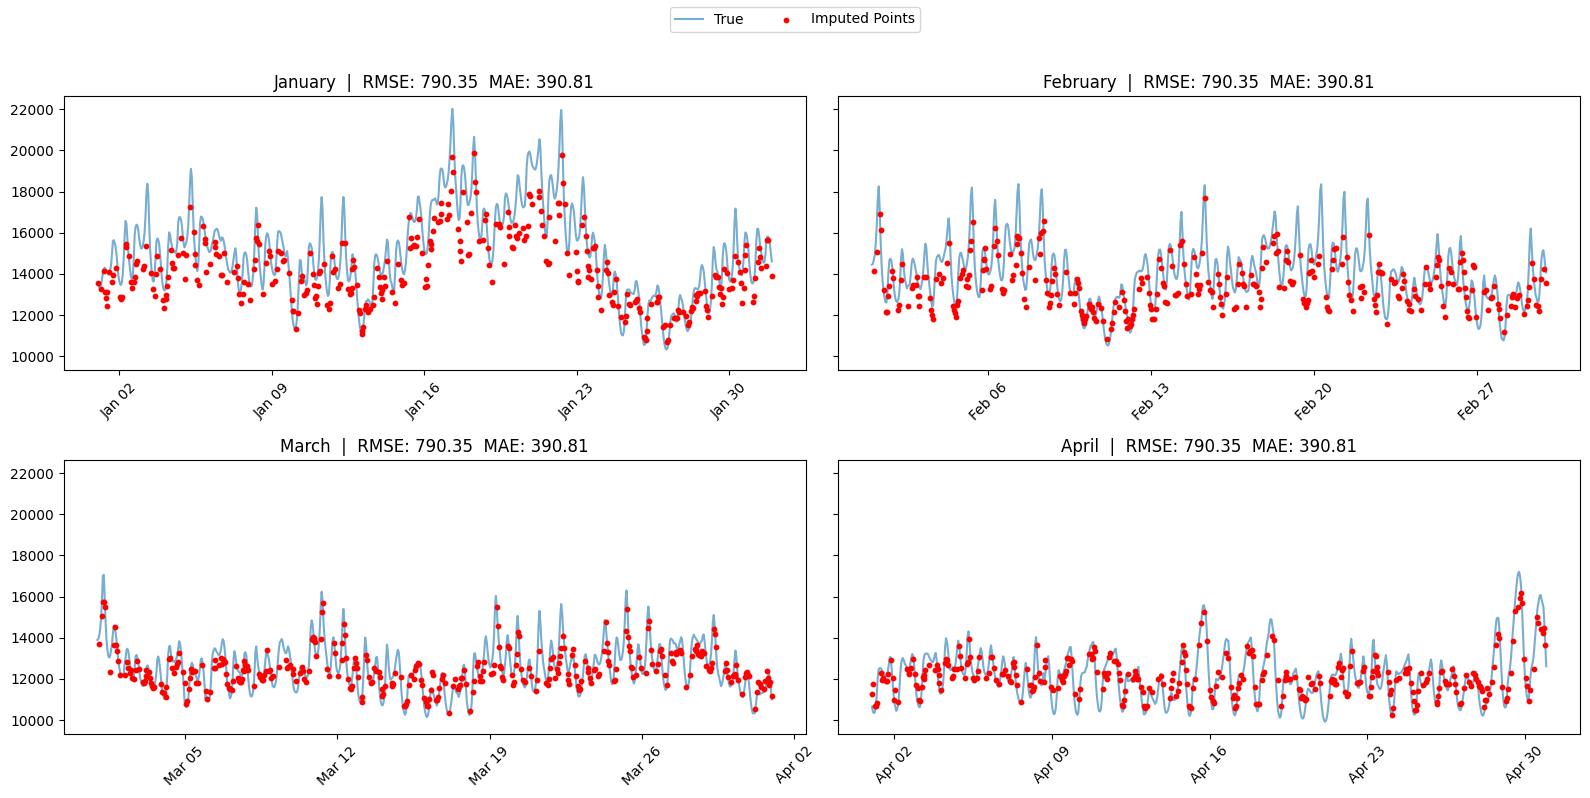

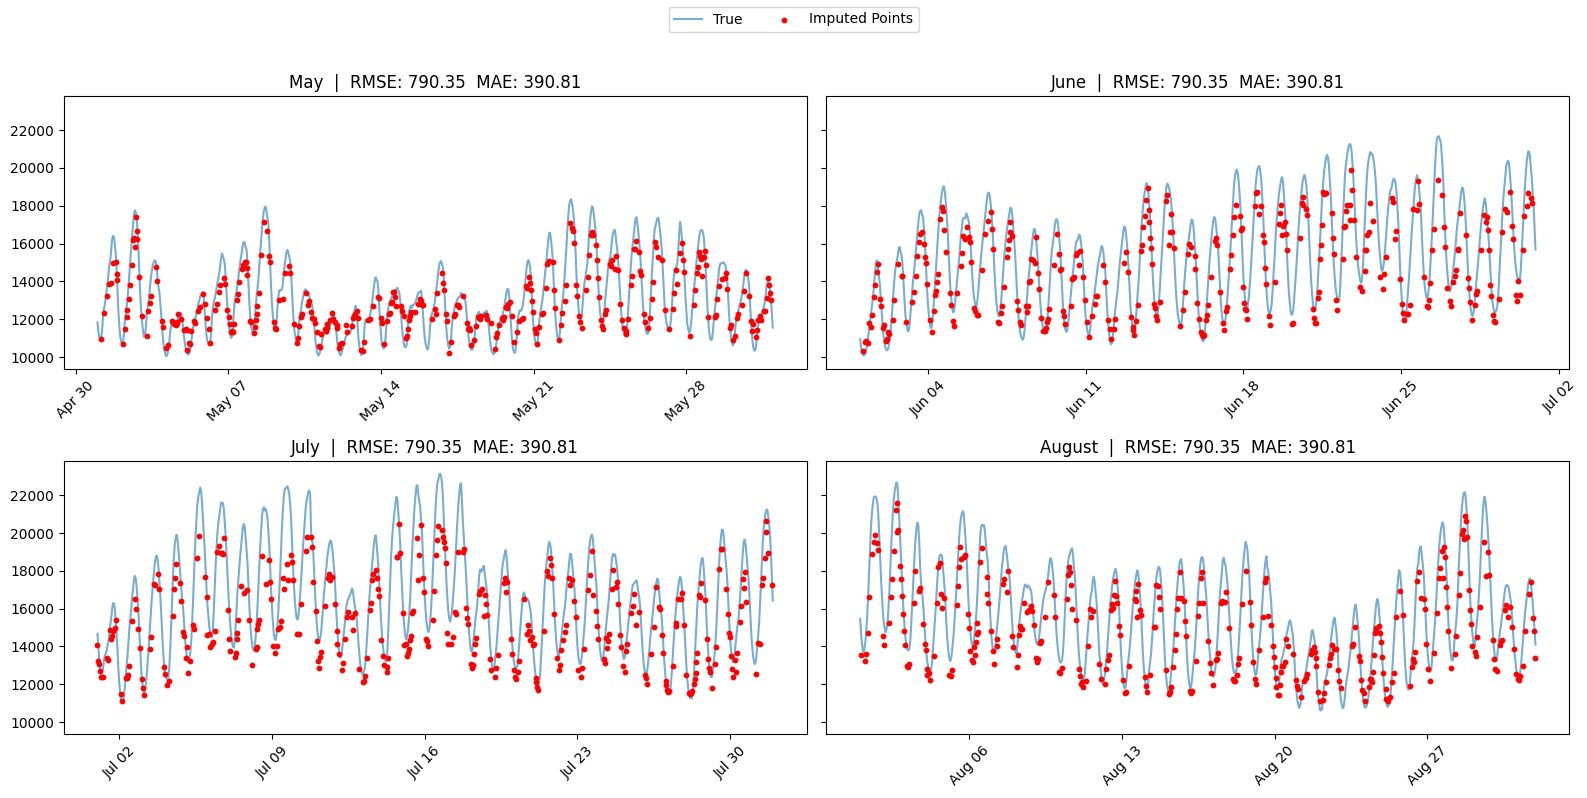

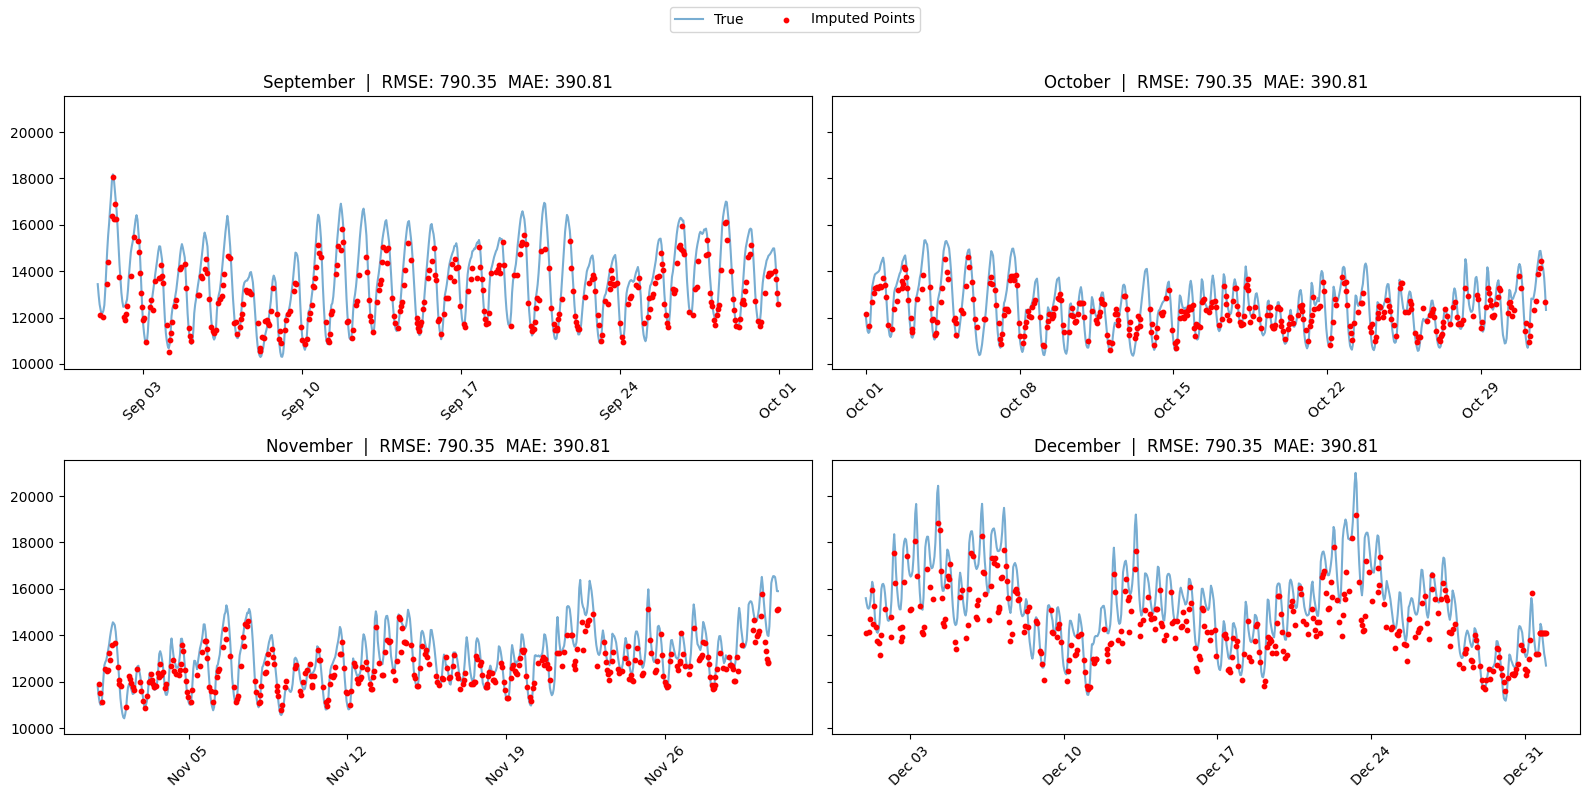

In [45]:
# ================== Load & Normalize ==================
pjm = df[df['year'] == 2024].reset_index(drop=True)
series = pjm['mw'].values.astype(np.float32)

mean, std = np.mean(series), np.std(series)
series_norm = (series - mean) / std

# ================== Slice Into Chunks ==================
def slice_sequences(series, seq_len=32, step=8, missing_rate=0.4, placeholder=-1.0):
    masked_seqs, true_seqs, masks = [], [], []
    for i in range(0, len(series) - seq_len, step):
        seq = series[i:i+seq_len]
        mask = np.ones(seq_len)
        masked = seq.copy()
        miss_idx = np.random.choice(seq_len, int(missing_rate * seq_len), replace=False)
        masked[miss_idx] = placeholder
        mask[miss_idx] = 0
        masked_seqs.append(masked)
        true_seqs.append(seq)
        masks.append(mask)
    return (
        np.array(masked_seqs)[..., np.newaxis].astype(np.float32),
        np.array(true_seqs)[..., np.newaxis].astype(np.float32),
        np.array(masks)[..., np.newaxis].astype(np.float32)
    )

X_input, Y_true, mask = slice_sequences(series_norm, seq_len=32, step=8, missing_rate=0.4)

# === Load Trained Model ===
generator = tf.keras.models.load_model("model_ep300_lr0.01_miss40_bs64.h5")

# === Predict Imputed Chunks ===
imputed_chunks = generator.predict(X_input)[:, :, 0]

# === Chunk-Level RMSE & MAE (Averaged Over All Chunks) ===
chunk_errors = (Y_true.squeeze(-1) - imputed_chunks)[mask.squeeze(-1) == 0]
chunk_rmse = np.sqrt(np.mean((chunk_errors * std) ** 2))
chunk_mae = np.mean(np.abs(chunk_errors * std))


# === Reconstruct Full Sequence ===
def reconstruct_full_sequence(chunks, total_len, seq_len=32, step=8):
    full = np.zeros(total_len)
    count = np.zeros(total_len)
    for i in range(chunks.shape[0]):
        start = i * step
        end = start + seq_len
        if end > total_len:
            break
        full[start:end] += chunks[i]
        count[start:end] += 1
    return np.divide(full, count, out=np.zeros_like(full), where=count != 0)

reconstructed = reconstruct_full_sequence(imputed_chunks, len(series_norm), seq_len=32, step=8)
reconstructed = reconstructed * std + mean
true_series = series_norm * std + mean

# === Reconstruct Mask ===
def reconstruct_mask(mask_chunks, seq_len=32, step=8, total_len=None):
    if total_len is None:
        total_len = (mask_chunks.shape[0] - 1) * step + seq_len
    full_mask = np.zeros(total_len)
    count = np.zeros(total_len)
    for i, m in enumerate(mask_chunks):
        start = i * step
        end = start + seq_len
        if end > total_len:
            break
        full_mask[start:end] += m.squeeze()
        count[start:end] += 1
    avg_mask = full_mask / np.maximum(count, 1)
    return (avg_mask > 0.5).astype(int)

mask_all = reconstruct_mask(mask, seq_len=32, step=8, total_len=len(series_norm))

# === Prepare DataFrame for Plotting ===
pjm['datetime'] = pd.to_datetime(pjm[['year', 'month', 'day', 'hour']])
pjm['true_mw'] = true_series
pjm['imputed_mw'] = reconstructed
pjm['mask'] = mask_all  # 1 = observed, 0 = missing

# === Monthly Plotting ===
month_groups = [[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12]]
for idx, group in enumerate(month_groups):
    fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharey=True)
    axes = axes.flatten()
    for i, month in enumerate(group):
        ax = axes[i]
        month_df = pjm[pjm['month'] == month]
        missing = month_df[month_df['mask'] == 0]

        if not missing.empty:
            rmse = np.sqrt(np.mean((missing['true_mw'] - missing['imputed_mw'])**2))
            mae = np.mean(np.abs(missing['true_mw'] - missing['imputed_mw']))
        else:
            rmse = mae = np.nan

        ax.plot(month_df['datetime'], month_df['true_mw'], label='True', alpha=0.6)
        ax.scatter(missing['datetime'], missing['imputed_mw'], color='red', s=10, label='Imputed Points', zorder=5)
        title = f"{pd.Timestamp(2024, month, 1).strftime('%B')}  |  RMSE: {chunk_rmse:.2f}  MAE: {chunk_mae:.2f}"
        ax.set_title(title)
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
        ax.tick_params(axis='x', rotation=45)

    for j in range(len(group), 4):
        fig.delaxes(axes[j])
    fig.tight_layout(rect=[0, 0, 1, 0.93])
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=3)
    plt.show()